# Crema D: 6 emotions

Features: MFCC

Models: Transformer Encoder

Accuracy: 0.4928

## Before running

In [1]:
import os
from datetime import datetime

dataset = "crema_d"
num_class = 6
use_label = "label_emotion"
use_all_data = True 
feature = 'mfcc'
feature_type = 'mfcc'

## Load data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from modules.dataloader import DataLoader

dataloader = DataLoader(dataset)
all_classes = dataloader.get_all_class()
class_info = dataloader.get_class_info(num_class=num_class)
classnames = class_info["classnames"]
classnames

['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS']

In [4]:
labels = dataloader.get_preprocessed_data(use_label)

In [5]:
feature_list = [feature]
lld = {}

for i in feature_list:
    d = dataloader.get_preprocessed_data(i)
    print(f"{i} (size, number of feature): {d.shape}")
    lld[i] = d

mfcc (size, number of feature): (7438,)


In [6]:
if not use_all_data:
    afilter = []

    for i, l in enumerate(labels):
        afilter += [all_classes[l] in classnames]

    labels = labels[afilter]
    for i in feature_list:
        lld[i] = lld[i][afilter]

    print(f"Data size of {num_class} classes: {labels.shape}")

In [7]:
from modules.train import Data, TensorDataLoader 
from modules.train import split_data
from modules.train_nn import create_data_loader_seq, transform_tensor

data_splitted = {}
data_loader = {}

for i in feature_list:
    d = Data(*split_data((lld[i], labels)))
    print(f"LLD{i}: X train {d.X_train.shape} - X test {d.X_test.shape}")
    dl, dt = create_data_loader_seq(d)
    data_loader[i] = dl
    data_splitted[i] = dt

LLDmfcc: X train (6322,) - X test (1116,)


## Transformer

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from visualize import display_module

### Multi-head attention

In [9]:
def multi_head_attention(Q, K, V, mask):
    """Multi-head attention on a batch of Q, K, V
    Arguments:
        Q: torch.Tensor shape (B, N, n_head, d_k)
        K: torch.Tensor shape (B, M, n_head, d_k)
        V: torch.Tensor shape (B, M, n_head, d_v)
        mask: torch.BoolTensor shape (B, N, M)
        where mask[i] is `mask` for attention of record i: (Q[i], K[i], V[i])
        
    Return:
        scaled-dot attention: torch.Tensor shape (B, N, n_head d_v)
    """
    B, N, n_head, d_k = Q.shape
    similar_score = torch.einsum('bnhd,bmhd->bhnm', Q, K) / (d_k ** 0.5)
    similar_score = similar_score.masked_fill(mask.unsqueeze(1), value=float("-inf"))
    attention_weight = F.softmax(similar_score, dim=-1)
    attentions = torch.einsum('bhnm,bmhd->bnhd', attention_weight, V)
    return attentions, attention_weight

### Encoder

config

In [10]:
from dataclasses import dataclass
 
@dataclass(init=True)
class TransformersConfig():
    tgt_vocab_size = 100
    src_vocab_size = 100
    seq_len = 165
    num_encoder_layers = 2       # Number of TransformerEncoderBlock layer in Encoder
    num_decoder_layers = 2       # Number of TransformerDecoderBlock layer in Decoder
    attn_dropout = 0.1           # Dropout for residual add after multi-head attention
    ff_dropout = 0.1             # Dropout for feed-forward residual add
    embed_dropout = 0.1          # Dropout for embedding after augmented wih positional encoding
    
    def __init__(self, feature=feature_type, num_class=num_class):
        self.num_class = num_class        # Number of output classes
        if feature == 'mfcc':
            self.d_model = 128                 # d_model = d_k * n_head
            self.d_k = 64
            self.d_v = 64
            self.n_head = int(self.d_model / self.d_k)     
            self.d_ff = self.d_k*self.d_v               # Number of unit in feed-forward layer
            self.src_pad_id = -1e5            # pad value 
        elif feature == 'cqt':
            self.d_model = 84                 # d_model = d_k * n_head
            self.d_k = 42
            self.d_v = 42
            self.n_head = int(self.d_model / self.d_k)     
            self.d_ff = self.d_k*self.d_v               # Number of unit in feed-forward layer
            self.src_pad_id = 1e-15            # pad value 
    
    
config = TransformersConfig(feature_type, num_class)
 
N_queries = config.d_k
M_keys = config.d_k
n_head = int(config.d_model / config.d_k)
batch_size = 32

In [11]:
print("Number of encoder layers: ", config.num_encoder_layers)

Number of encoder layers:  2


In [12]:
print(config.d_model)
print(config.n_head)
print(config.num_class)

128
2
6


FeedForwardAddNorm

In [13]:
class FeedForwardAddNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear1 = nn.Linear(config.d_model, config.d_ff)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(config.d_ff, config.d_model)
        self.dropout = nn.Dropout(config.ff_dropout)
        self.layer_norm = nn.LayerNorm(config.d_model)
        
    def forward(self, input):
        x = self.linear1(input)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x += input
        x = self.layer_norm(x)
        return x
        

FeedForwardAddNorm(
  (linear1): Linear(in_features=128, out_features=4096, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=4096, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)
aten::add_ %input : Float(32, 165, 128, strides=[21120, 128, 1], requires_grad=1, device=cpu) = aten::add_(%62, %input.1, %31) # /tmp/ipykernel_29433/2149057323.py:15:0



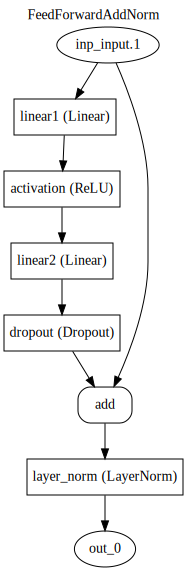

In [14]:
"""Simple test"""
ff = FeedForwardAddNorm(config)
print(ff)
inps = torch.randn(batch_size, config.seq_len, config.d_model)
outs = ff(inps)
assert outs.shape == inps.shape
d = display_module(ff, inps)
d

AttentionAddNorm

In [15]:
class AttentionAddNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.Q_proj = nn.Linear(config.d_model, config.d_model)
        self.K_proj = nn.Linear(config.d_model, config.d_model)
        self.V_proj = nn.Linear(config.d_model, config.d_model)
        self.dropout = nn.Dropout(config.attn_dropout)
        self.layer_norm = nn.LayerNorm(config.d_model)
        
    def forward(self, query, key, value, mask):
        Q, K, V = self.Q_proj(query), self.K_proj(key), self.V_proj(value)
        Q = rearrange(Q, "B seq_len (n_head d_k) -> B seq_len n_head d_k", n_head=self.config.n_head)
        K = rearrange(K, "B seq_len (n_head d_k) -> B seq_len n_head d_k", n_head=self.config.n_head)
        V = rearrange(V, "B seq_len (n_head d_v) -> B seq_len n_head d_v", n_head=self.config.n_head)
        attention, similar_score = multi_head_attention(Q, K, V, mask)
        attention = self.dropout(attention)
        attention = rearrange(attention, "B seq_len n_head d_v -> B seq_len (n_head d_v)")
        return self.layer_norm(query + attention), similar_score

AttentionAddNorm(
  (Q_proj): Linear(in_features=128, out_features=128, bias=True)
  (K_proj): Linear(in_features=128, out_features=128, bias=True)
  (V_proj): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)


/home/linh-miaw/anaconda3/envs/py39/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


aten::einsum %164 : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::einsum(%162, %163) # /home/linh-miaw/anaconda3/envs/py39/lib/python3.9/site-packages/torch/functional.py:299:0

aten::div %similar_score : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::div(%164, %166) # /tmp/ipykernel_29433/631784733.py:14:0

aten::masked_fill %input.1 : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::masked_fill(%similar_score, %169, %170) # /tmp/ipykernel_29433/631784733.py:15:0

aten::softmax %174 : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::softmax(%input.1, %172, %173) # /home/linh-miaw/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:1679:0

aten::einsum %input.3 : Float(32, 165, 2, 64, strides=[21120, 64, 10560, 1], requires_grad=1, device=cpu) = aten::einsum(%175, %176) # /home/linh-miaw/anaco

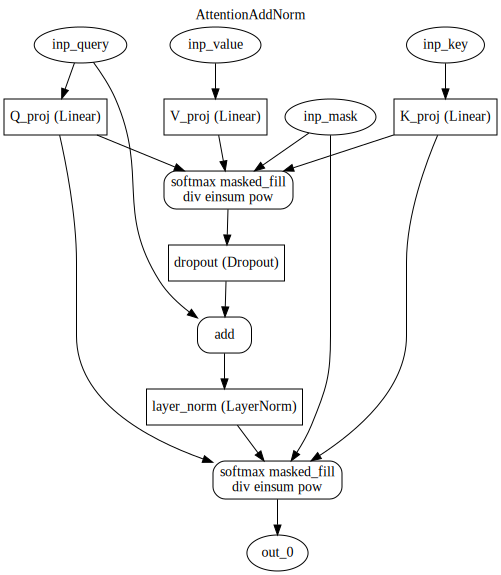

In [16]:
"""Simple test"""
aa = AttentionAddNorm(config)
print(aa)
q = torch.randn(batch_size, config.seq_len, config.d_model)
k = torch.randn(batch_size, config.seq_len, config.d_model)
v = torch.randn(batch_size, config.seq_len, config.d_model)
mask = torch.randint(low=0, high=32, size=(batch_size, config.seq_len, config.seq_len)).eq(3)

outs, _ = aa(q, k, v, mask)
assert outs.shape == q.shape

d = display_module(aa, [q, k, v, mask])
d

EncoderBlock

In [17]:
class EncoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attention = AttentionAddNorm(config)
        self.feed_forward = FeedForwardAddNorm(config)
        
    def forward(self, src_embeddings, src_masks):
        x, _ = self.self_attention(src_embeddings, src_embeddings, src_embeddings, src_masks)
        return self.feed_forward(x)

aten::einsum %141 : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::einsum(%139, %140), scope: __module.self_attention # /home/linh-miaw/anaconda3/envs/py39/lib/python3.9/site-packages/torch/functional.py:299:0

aten::div %similar_score : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::div(%141, %143), scope: __module.self_attention # /tmp/ipykernel_29433/631784733.py:14:0

aten::masked_fill %input.1 : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::masked_fill(%similar_score, %146, %148), scope: __module.self_attention # /tmp/ipykernel_29433/631784733.py:15:0

aten::softmax %152 : Float(32, 2, 165, 165, strides=[54450, 27225, 165, 1], requires_grad=1, device=cpu) = aten::softmax(%input.1, %150, %151), scope: __module.self_attention # /home/linh-miaw/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:1679:0

aten::einsum %input.3 : Floa

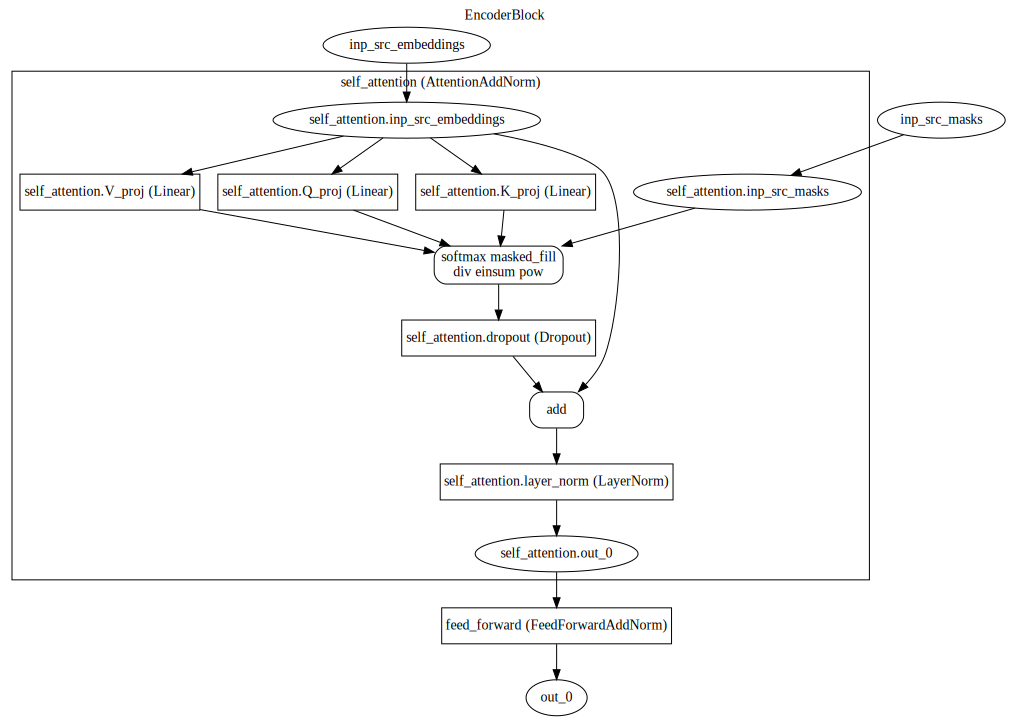

In [18]:
"""Simple test"""
block = EncoderBlock(config)
src_embedding = torch.randn(batch_size, config.seq_len, config.d_model)
src_mask = torch.randint(low=0, high=32, size=(batch_size, config.seq_len, config.seq_len)).eq(3)

outs = block(src_embedding, src_mask)
assert outs.shape == src_embedding.shape
d = display_module(block, [src_embedding, src_mask], classes_to_visit={"AttentionAddNorm"})
d

In [19]:
def generate_positional_encoding(seq_len, d_model):
    """ Return sinusoid matrix `pe` with shape seq_len x d_model
    Arguments:
        seq_len: max number of tokens for a sequence
        d_model: length of vector position
    Return:
        pe: position encoding matrix in Vaswani et al,.
        pe is a matrix with shape (seq_len, d_model)
        and 
        pe[pos_id, 2i] =  sin(pos_id/10000^(2i / d_model)) 
        pe[pos_id, 2i+1] =  cos(pos_id/10000^(2i / d_model)) 
    """
    t = np.array([1/10000**(2*i / d_model) for i in range(d_model//2)])
    pe = [np.ravel([np.sin(pos_id*t), np.cos(pos_id*t)], 'F') for pos_id in range(seq_len)]
    pe = torch.tensor(pe)
    return pe

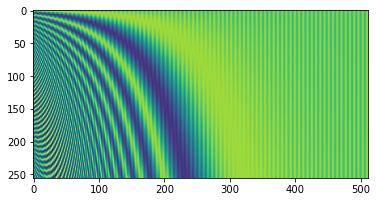

In [20]:
"""Simple test"""
pe = generate_positional_encoding(256, 512)
assert pe.shape == (256, 512)
assert pe[0, 0::2].sum() == 0 
assert pe[0, 1::2].sum() == 512/2
plt.imshow(pe)
plt.show()

### Embedding for sound?

For sound file, we already extract features with `model_dim`, so no need to get embedding. 
We also don't need positional encoding. 

Now we only have to calculate `src_mask` sequences.

In [21]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for i in range(config.num_encoder_layers):
            self.blocks.append(EncoderBlock(config))

    def forward(self, src_ids, src_mask):
        x = src_ids
        for encoder in self.blocks:
            x = encoder(x, src_mask)
        return x

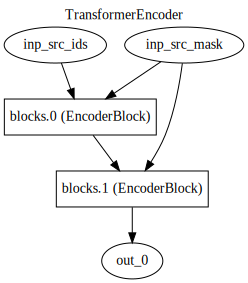

In [22]:
"""Simple test"""
inp = torch.rand(size=(batch_size, config.seq_len, config.d_model))
mask = torch.zeros(batch_size, config.seq_len, config.seq_len)
encoder = TransformerEncoder(config)
out = encoder(inp, mask)
assert out.shape == (batch_size, config.seq_len, config.d_model)
d = display_module(encoder, [inp, mask])
d

### causal mask

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


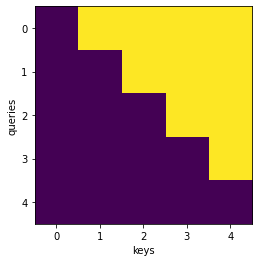

In [23]:
def generate_causal_mask(size):
    """Generate subsequent mask
    Arguments:
        size: int, number of decode steps
    Return:
        mask: torch.LongTensor shape (size, size)
        where mask[i, :i+1] = 0, and mask[i, i+1:] = 1
    """
    mask = torch.ones((size, size))
    # triu: Upper triangular, diagonal=1 mean
    # we take the first upper (include diagonal)
    return torch.triu(mask, diagonal=1).bool()

mask = generate_causal_mask(5)
print(mask)
plt.imshow(mask.numpy())
plt.xlabel("keys")
plt.ylabel("queries")
plt.show()

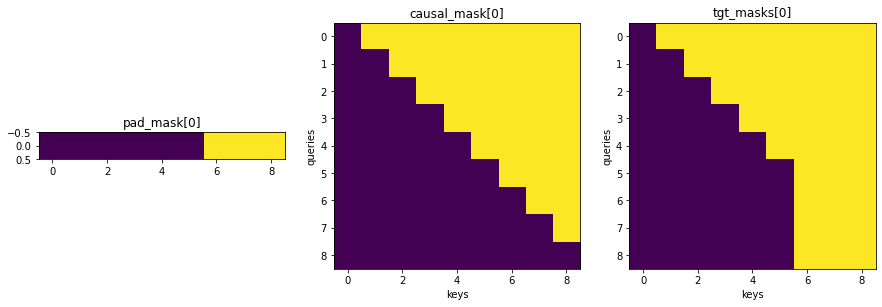

In [24]:
tgt_indices = torch.tensor([[2, 10, 8, 6, 14, 3, 4, 4, 4]]).long() # <BOS> I go to school <EOS> <PAD> <PAD>
pad_id   = 4
seq_len = tgt_indices.size(1)
pad_mask = tgt_indices.eq(pad_id) # B, seq_len
causal_mask = generate_causal_mask(seq_len) # seq_len seq_len
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("pad_mask[0]")
plt.imshow(pad_mask.numpy())

plt.subplot(1, 3, 2)
plt.title("causal_mask[0]")
plt.imshow(causal_mask.numpy())
plt.xlabel("keys")
plt.ylabel("queries")

tgt_mask = pad_mask.unsqueeze(1).repeat((1, seq_len, 1)) | causal_mask  # OR operator

plt.subplot(1, 3, 3)
plt.title("tgt_masks[0]")
plt.imshow(tgt_mask[0].numpy())
plt.xlabel("keys")
plt.ylabel("queries")
plt.show()

### classifier

fix: encoder_output (32 x 165 x 128) => (32 x 128) => (32 x 8)

In [25]:
class ClassifierBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        d = self.config.d_model
        self.dense = nn.Sequential( 
            nn.Linear(d,d),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(d,d),
            nn.LeakyReLU(),
            nn.Linear(d, self.config.num_class),
            nn.LeakyReLU(),
            nn.Softmax(1)
        )

    def forward(self, encoder_output, src_mask=None):
        src_mask = src_mask[:,:,0].bool().unsqueeze(2)
        encoder_output_mean = torch.masked_select(encoder_output,~src_mask)
        encoder_output_mean = encoder_output_mean.view(encoder_output.size()[0],-1,self.config.d_model)
        encoder_output_mean = encoder_output_mean.mean(dim=1)
        out_logits = self.dense(encoder_output_mean)
        return out_logits


torch.Size([32, 6])
aten::bitwise_not %58 : Bool(32, 165, 1, strides=[165, 1, 1], requires_grad=0, device=cpu) = aten::bitwise_not(%src_mask) # /tmp/ipykernel_29433/2830721892.py:19:0

aten::masked_select %encoder_output_mean.1 : Float(675840, strides=[1], requires_grad=0, device=cpu) = aten::masked_select(%encoder_output, %58) # /tmp/ipykernel_29433/2830721892.py:19:0

aten::mean %input.1 : Float(32, 128, strides=[128, 1], requires_grad=0, device=cpu) = aten::mean(%encoder_output_mean, %75, %76, %77) # /tmp/ipykernel_29433/2830721892.py:21:0



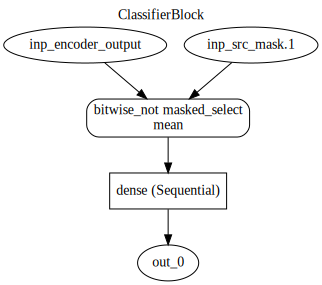

In [26]:
"""Simple Test"""
src_ids = torch.rand(size=(batch_size, config.seq_len, config.d_model))
src_mask = torch.zeros(batch_size, config.seq_len, config.seq_len)
encoder_output = torch.randn(batch_size, config.seq_len, config.d_model)

classifier_block = ClassifierBlock(config)
input = [encoder_output, src_mask]
out_logits = classifier_block(*input)
print(out_logits.shape)

d = display_module(classifier_block, input, classes_to_visit={})
d

In [27]:
class TransformerEncoderClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.src_pad_id = config.src_pad_id
        self.encoder = TransformerEncoder(config)
        self.classifier = ClassifierBlock(config)
        self.register_buffer("causal_mask", generate_causal_mask(config.seq_len))
        self.apply(self._init_weights)

    def forward(self, src_ids):
        src_mask = self.make_src_mask(src_ids)
        encoder_output = self.encoder(src_ids, src_mask)
        out_logits = self.classifier(encoder_output, src_mask)
        return out_logits

    def make_src_mask(self, src_ids):
        """Return PAD mask for source ids shape (B, seq_len, seq_len)"""
        src_mask = src_ids[:,:,0].eq(self.src_pad_id)
        src_mask = src_mask.unsqueeze(1).repeat((1, self.config.seq_len, 1))
        return src_mask

    def _init_weights(self, module):
        # this initializer was copied from https://github.com/karpathy/minGPT/blob/master/mingpt/model.py#L125
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

torch.Size([32, 6])
aten::eq %src_mask.1 : Bool(32, 165, strides=[165, 1], requires_grad=0, device=cpu) = aten::eq(%165, %166) # /tmp/ipykernel_29433/3928439995.py:19:0

aten::repeat %mask : Bool(32, 165, 165, strides=[27225, 165, 1], requires_grad=0, device=cpu) = aten::repeat(%169, %173) # /tmp/ipykernel_29433/3928439995.py:20:0

aten::bitwise_not %23 : Bool(32, 165, 1, strides=[165, 1, 1], requires_grad=0, device=cpu) = aten::bitwise_not(%src_mask), scope: __module.classifier # /tmp/ipykernel_29433/2830721892.py:19:0

aten::masked_select %encoder_output_mean.1 : Float(675840, strides=[1], requires_grad=1, device=cpu) = aten::masked_select(%25, %23), scope: __module.classifier # /tmp/ipykernel_29433/2830721892.py:19:0

aten::mean %input.35 : Float(32, 128, strides=[128, 1], requires_grad=1, device=cpu) = aten::mean(%encoder_output_mean, %41, %42, %43), scope: __module.classifier # /tmp/ipykernel_29433/2830721892.py:21:0



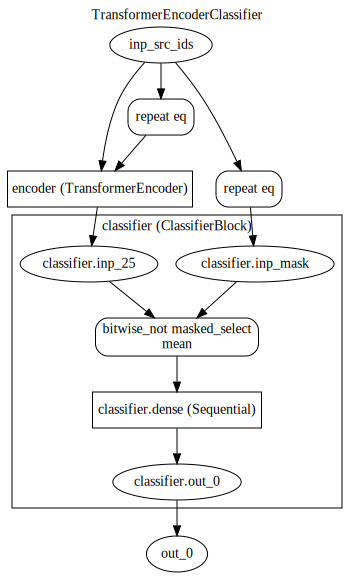

In [28]:
"""Simple Test"""
# to run test faster and not crashing the current session
src_ids = torch.rand(size=(batch_size, config.seq_len, config.d_model))
tfm = TransformerEncoderClassifier(config)

input = [src_ids]
out_logits = tfm(*input)
print(out_logits.shape)

d = display_module(tfm, input, classes_to_visit={"ClassifierBlock"}) # It's gonna take a while ...
d

## Train with transformer

In [29]:
import pytorch_lightning as pl
pl.seed_everything(42)

Global seed set to 42


42

In [30]:
from torchmetrics import Accuracy, MetricCollection

class LightningModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = TransformerEncoderClassifier(self.config)
        
        self.criterion = nn.CrossEntropyLoss()
        metrics = MetricCollection([Accuracy()])
        self.train_metrics = metrics.clone(prefix='train_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, src_ids, tgt_emo_id):
        # src_ids: B x seq_len
        logits = self.model(src_ids)
#         loss = F.cross_entropy(torch.transpose(logits, 1, 2), tgt_emo_id) ##TODO: Loss
        return logits

    def training_step(self, batch, batch_idx):
        # src_ids shape (B, seq_len)
        src_ids, tgt_emo_id = batch  
        logits = self.model(src_ids)#.mean(dim=1)
        loss = self.criterion(logits, tgt_emo_id)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        
        output = self.train_metrics(logits, tgt_emo_id)
        # use log_dict instead of log
        # metrics are logged with keys: train_Accuracy, train_Precision and train_Recall
        self.log_dict(output)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)#.mean(dim=1)
        loss = self.criterion(y_hat, y)
        # Logging to TensorBoard by default
        self.log('test_loss', loss)
        output = self.test_metrics(y_hat, y)
        self.log_dict(output)
        return loss

    def configure_optimizers(self):
        # From this issue: https://github.com/PyTorchLightning/pytorch-lightning/issues/2673
        # This optimizer was copied from
        # https://colab.research.google.com/drive/1e7h54IlrtjdifjKu2wK3fDyzp4ZVyacP?usp=sharing#scrollTo=bB9m-goqHw3e
        # it helps overcome nan loss with fp16 ¯\_(ツ)_/¯
        "Prepare optimizer and schedule (linear warmup and decay)"
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
#         optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=1e-4, eps=1e-8)
        return optimizer


In [31]:
print(torch.backends.cudnn.is_available())
print(torch.cuda.is_available())
print(torch.version.cuda)

True
True
11.1


In [32]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 5394), started 6:50:24 ago. (Use '!kill 5394' to kill it.)

In [33]:
 %reload_ext tensorboard

In [34]:
torch.autograd.set_detect_anomaly(True)

In [35]:
litmodel = LightningModel(config)

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(
    max_epochs=50,
#     callbacks=[EarlyStopping(monitor='train_loss')],
    gpus=1,
    gradient_clip_val=1.,
#     val_check_interval=0.5,    # do validation twice every epoch
    precision=16               # floating precision 16 make training faster (~5x faster),
)
trainer.fit(litmodel, data_loader[feature].train)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                         | Params
---------------------------------------------------------------
0 | model         | TransformerEncoderClassifier | 2.2 M 
1 | criterion     | CrossEntropyLoss             | 0     
2 | train_metrics | MetricCollection             | 0     
3 | test_metrics  | MetricCollection             | 0     
---------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.958     Total estimated model params size (MB)
/home/linh-miaw/anaconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: -1it [00:00, ?it/s]

/home/linh-miaw/anaconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/plugins/precision/precision_plugin.py:138: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(parameters, clip_val)


In [36]:
# PATH = "./lightning_logs/version_58/checkpoints/epoch=49-step=9899.ckpt"
# litmodel = LightningModel.load_from_checkpoint(PATH, config=config)
# litmodel

In [37]:
import torchmetrics
pred_model = litmodel.model
pred_model.eval()
preds = pred_model(data_splitted[feature].X_test)
target = data_splitted[feature].Y_test

acc = torchmetrics.functional.accuracy(preds, target)
acc

tensor(0.4928)